In [41]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [42]:
PATH = '/home/baitong/pywork/cellDetection/all/'
TRAIN = PATH+'train_all/'
TEST = PATH+'test/'
LABELS = PATH+'train_all.csv'
SAMPLE = PATH+'sample_submission.csv'
SUB = PATH+'sub2/'
nw = 2 
model_name = 'wrn_all'
arch = wrn

In [43]:
# train_v1 = pd.read_csv(PATH+'train.csv')
# train_v2 = pd.read_csv(PATH+'HPAv18RBGY_wodpl.csv')
# train_all = pd.concat([train_v1,train_v2],axis=0)
# train_all.to_csv(PATH+'train_all.csv',index=False)

In [44]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [45]:
train_names = []
for f in os.listdir(TRAIN):
    colors = ['red','green','blue','yellow']
    for col in colors:
        if col in f:
            train_names.append(f[:-len('_'+col+'.png')])
# train_names = list({f[:36] for f in os.listdir(TRAIN)})
train_set = list(set(train_names))

In [46]:
len(train_set)

76158

In [47]:
miss_list = ['54197_877_C3_5','35764_1364_B10_1','39292_1468_E4_3','40720_547_E1_1','51109_736_B11_2',
'52757_1472_A10_10','10145_944_B10_2','36409_571_G9_1','41174_510_G2_2']
# for item in train_set:
#     if train_names.count(item) !=4:
#         miss_list.append(item)
#         print(item)

In [48]:
for err_ in miss_list:
    train_set.remove(err_)
train_names = train_set

In [49]:
len(train_names)

76149

In [52]:
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)
len(tr_n)

68534

In [51]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,LABELS))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

69895


In [11]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(path+id+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [12]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
          
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [13]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [14]:
bs = 16
sz = 512
md = get_data(sz,bs)
x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 512, 512]), torch.Size([16, 28]))

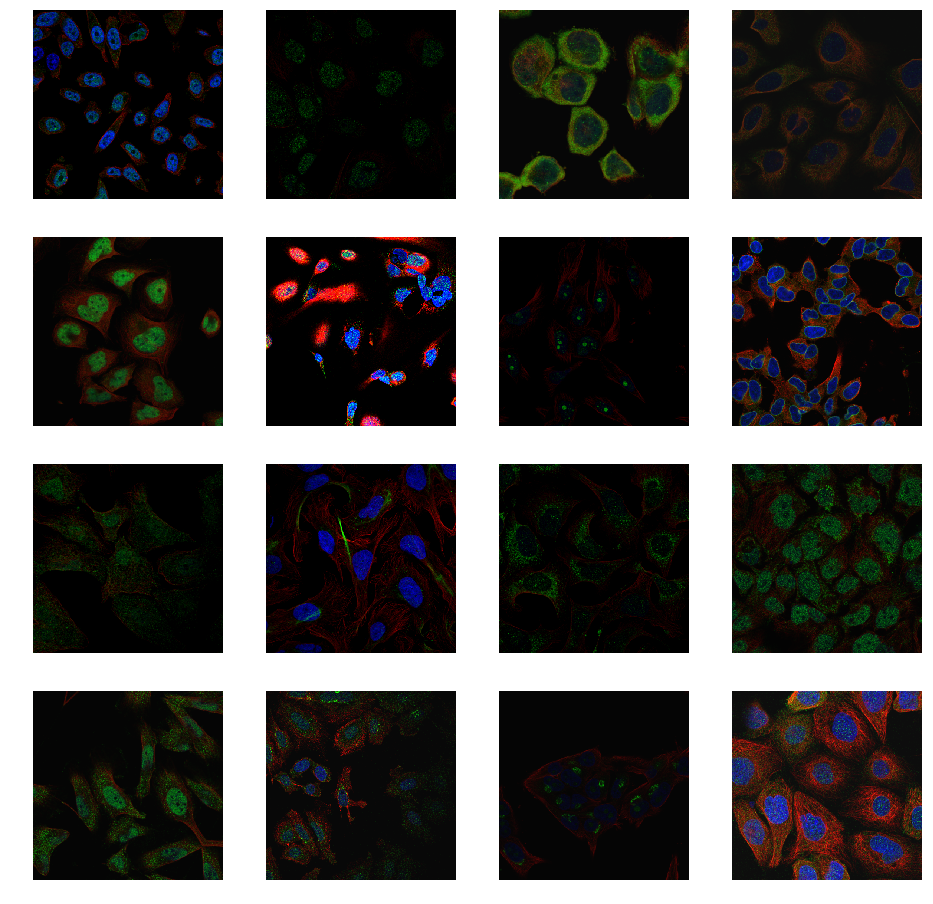

In [15]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [17]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [18]:

class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
#         ??cut_model
#         print('layers[0]',(layers[0]))
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
#         print(type(layers[0].conv))        
#         w = layers[0][0].conv.weight
        w = layers[0].weight
#         print(layers[0][0])
#         layers[0][0].conv= nn.Conv2d(4,32,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0] = nn.Conv2d(4,32,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
    
#         layers[0][0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
        layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [19]:
bs = 8
sz = 512
md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50% inceptionnet x_cut=1
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

/home/baitong/tensorflow/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/baitong/tensorflow/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [20]:
import warnings 
warnings.filterwarnings('ignore')

 63%|██████▎   | 5433/8566 [27:52<15:57,  3.27it/s, loss=5.03] 

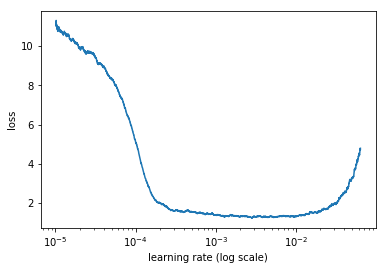

In [21]:
learner.lr_find()
learner.sched.plot()

In [22]:
lr = 0.3e-3
learner.fit(lr,1)

epoch      trn_loss   val_loss   acc                          
    0      1.154208   1.065376   0.952744  


[1.0653762044831474, 0.9527436444106575]

In [23]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [24]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                             
    0      0.868115   0.762488   0.967048  
    1      0.786222   0.699816   0.969234                        
    2      0.798219   0.703707   0.969074                        
    3      0.73445    0.659795   0.970772                        
    4      0.718617   0.669292   0.97019                         
    5      0.712123   0.649339   0.971269                        
    6      0.725232   0.661051   0.971044                        
    7      0.677797   0.627622   0.972071                        


[0.6276218997046733, 0.9720711011598553]

In [25]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                             
    0      0.677557   0.644926   0.971396  
    1      0.682387   0.635425   0.971813                        
    2      0.621604   0.630368   0.97186                         
    3      0.687188   0.61397    0.97277                         
    4      0.694728   0.646685   0.971579                        
    5      0.682598   0.630132   0.972118                        
    6      0.629619   0.61269    0.972709                        
    7      0.624312   0.595832   0.973347                        


[0.5958319753428, 0.9733467797112167]

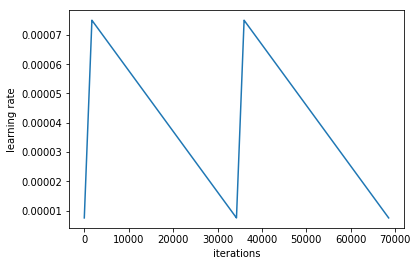

In [26]:
learner.sched.plot_lr()

In [27]:
learner.save(model_name+'-2')

In [28]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc                             
    0      0.619783   0.600959   0.973403  
    1      0.665524   0.600598   0.973145                        
    2      0.644396   0.5959     0.973548                        
    3      0.602882   0.604712   0.973328                        
    4      0.579573   0.592401   0.973633                        
    5      0.580724   0.595446   0.973694                        
    6      0.590291   0.590667   0.973717                        
    7      0.640354   0.589829   0.973919                        


[0.5898292797338156, 0.9739189580640586]

In [29]:
learner.save(model_name+'all')

In [30]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [31]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [32]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.52772 0.53363 0.52093 0.54847 0.5221  0.52779 0.53091 0.51754 0.55811 0.4654  0.39642 0.49896 0.67084
 0.55174 0.56378 0.53514 0.68257 0.68796 0.52571 0.53087 0.4954  0.45798 0.57298 0.54393 0.64959 0.50187
 0.57249 0.3315 ]
F1 macro:  0.6650937377908183
F1 macro (th = 0.5):  0.6145987727739787
F1 micro:  0.7593075048323388


In [33]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.42219 0.02692 0.0956  0.03257 0.04557 0.05016 0.03401 0.07367 0.00289 0.00026 0.00013 0.02337 0.01326
 0.0109  0.02837 0.00013 0.0067  0.00394 0.01891 0.03336 0.0046  0.13946 0.01668 0.08247 0.00407 0.3782
 0.00302 0.00066]
Fractions (true):  [0.39659 0.02731 0.10742 0.03598 0.05121 0.06106 0.03743 0.08562 0.00223 0.00066 0.00053 0.02521 0.02062
 0.01313 0.03007 0.00013 0.01234 0.00446 0.01983 0.03506 0.00433 0.14012 0.02193 0.08746 0.0046  0.33959
 0.00657 0.00158]


In [34]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [35]:
def save_pred(pred, th=0.5, fname='sub2/'+model_name+'protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [36]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.41412 0.05452 0.08452 0.07093 0.09785 0.12417 0.07913 0.09904 0.00265 0.00094 0.00077 0.0582  0.05546
 0.0247  0.05213 0.00009 0.05555 0.04264 0.0482  0.09144 0.01034 0.14921 0.04358 0.09716 0.0135  0.29354
 0.04435 0.04102]


In [37]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [38]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [39]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.60835 0.48979 0.58885 0.38499 0.38243 0.50272 0.43136 0.52868 0.16266 0.17038 0.16092 0.52092 0.35906
 0.59164 0.581   0.16431 0.5726  0.81049 0.56455 0.50289 0.40335 0.53851 0.48529 0.55501 0.58791 0.59349
 0.39442 0.17404]
Fractions:  [0.36327 0.04333 0.07435 0.05717 0.07298 0.07494 0.04358 0.07486 0.0082  0.00889 0.00769 0.04367 0.04273
 0.0141  0.04401 0.00667 0.02854 0.01436 0.02854 0.05854 0.00983 0.12323 0.02846 0.07537 0.01017 0.22073
 0.0282  0.00598]
Fractions (th = 0.5):  [0.48573 0.04239 0.0987  0.03811 0.04538 0.0758  0.02905 0.08289 0.00154 0.00051 0.00026 0.04521 0.02504
 0.0176  0.05119 0.00009 0.03555 0.03469 0.03905 0.05948 0.00632 0.15262 0.02717 0.08836 0.01162 0.36464
 0.01589 0.00009]


In [40]:
# save_pred(pred_t,th_t,'sub2/'+model_name+'protein_classification_f.csv')
save_pred(pred_t,th,'sub2/'+model_name+'protein_classification_v.csv')
save_pred(pred_t,0.5,'sub2/'+model_name+'protein_classification_05.csv')